# 1.IMPORT LIBRARIES

In [5]:
# 1. Các thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import adfuller

# 2. READING AND PROCESSING DATA

In [6]:
df = pd.read_excel("/kaggle/input/eth-data/processed_data.xlsx")

df = df.reset_index(drop=True) # Reset the index

# 4. CHECK ADF TEST TO SEE IF THE DATA IS STATIONARY

In [7]:
# Function to test stationarity using ADF test
def adf_test(timeseries):
    timeseries.replace([np.inf, -np.inf], np.nan, inplace=True)
    timeseries.dropna(inplace=True)
    result = adfuller(timeseries, autolag='AIC')

    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:', result[4])

    # Check the p-value
    if result[1] <= 0.05:
        print("Reject the null hypothesis. Data is stationary.")
    else:
        print("Fail to reject the null hypothesis. Data is non-stationary.")

# Test the stationarity of the data
adf_test(df['Close'])

ADF Statistic: -1.157288176148786
p-value: 0.6916942916001724
Critical Values: {'1%': -3.433794582887893, '5%': -2.8630615877583185, '10%': -2.567580035583033}
Fail to reject the null hypothesis. Data is non-stationary.


# 5. THE RESULT SHOW THAT THE DATA IS NON-STATIONARY
 SO WE NEED TO USE METHOD TO MAKE IT STATIONARY - IN HERE IS DIFF METHOD

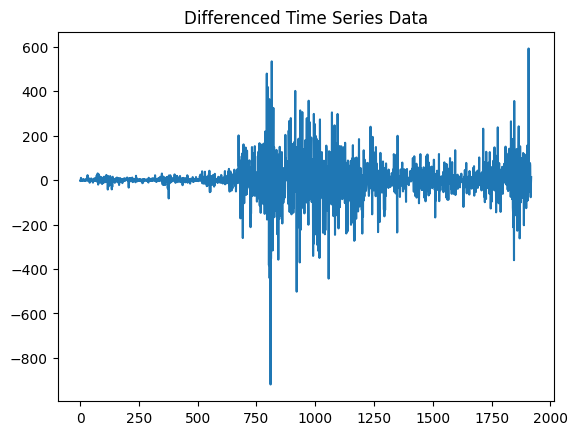

ADF Statistic: -10.890710992996937
p-value: 1.227198024795975e-19
Critical Values: {'1%': -3.433794582887893, '5%': -2.8630615877583185, '10%': -2.567580035583033}
Reject the null hypothesis. Data is stationary.


In [8]:
# Take the first difference to make the data stationary
df['Close_diff'] = df['Close'].diff().dropna()

# Visualize the differenced data (if needed)
plt.plot(df['Close_diff'])
plt.title('Differenced Time Series Data')
plt.show()

# Test the stationarity of the differenced data
adf_test(df['Close_diff'])

# 6. NOW THE P-VALUE IS < 0.05 SO THE DATA IS STATIONARY
Next we will import auto_arima to find the best model


In [9]:
!pip install pmdarima


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 17.0 MB/s eta 0:00:0000:010:01


In [10]:
from pmdarima import auto_arima
import warnings
warnings.filterwarnings('ignore')

In [11]:
# Split the data into training, testing, and validation sets 6:2:2
train_size = int(0.7 * len(df))
test_size = int(0.2* len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]


x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Close'])

In [12]:
model = auto_arima(y_train, trace=True, error_action='ignore', suppress_warnings=True)
model.fit(y_train)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=15897.693, Time=1.99 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=15898.855, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=15894.110, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=15894.378, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=15897.030, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=15895.793, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=15895.940, Time=0.11 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=15896.447, Time=0.80 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=15892.312, Time=0.07 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=15893.990, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=15894.138, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=15892.580, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=15894.621, Time=0.24 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 3.817 seconds


ARIMA(order=(1, 1, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

# 7. THE BEST ARIMA MODEL IS (1,1,1)


In [13]:
# 4. Quá trình testing
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Close'])
y_pred = model.predict(n_periods=len(y_test))

# 5. Quá trình Validate
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Close'])
y_pred_val =  model.predict(n_periods=len(y_val))

# 8. ACCURACY ASSESSMENT

In [14]:
# 7. Đánh giá độ chính xác validate, test
from sklearn.metrics import mean_squared_error, mean_absolute_error

valid_rmse = np.sqrt(np.mean((y_pred_val - y_val)**2))
valid_mse = mean_squared_error(y_val, y_pred_val)
valid_mae = np.mean(np.abs(y_pred_val - y_val))
valid_mape = np.mean(np.abs((y_pred_val - y_val) / y_val)) * 100

test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
test_mse = mean_squared_error(y_test, y_pred)
test_mae = np.mean(np.abs(y_pred - y_test))
test_mape = np.mean(np.abs((y_pred - y_test) / y_test)) * 100

print('Validation RMSE:', valid_rmse)
print('Validation MSE:', valid_mse)
print('Validation MAE:', valid_mae)
print('Validation MAPE:', valid_mape)

print('Testing RMSE:', test_rmse)
print('Testing MSE:', test_mse)
print('Testing MAE:', test_mae)
print('Testing MAPE:', test_mape)

Validation RMSE: 1477.0350214023765
Validation MSE: 2181632.454449119
Validation MAE: 1358.326896892203
Validation MAPE: 44.93554705352308
Testing RMSE: 277.8368797904181
Testing MSE: 77193.33177167522
Testing MAE: 244.78095144804234
Testing MAPE: 14.68942686459631


<h2> 30 days

In [15]:
# 6. Quá trình tạo index predict 30 ngày tiếp theo
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

# Create an array of 30 consecutive integers starting from last_index
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

# Predict the closing prices for the next 30 days
y_next_30_days = model.predict(n_periods=len(x_next_30_days))

# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
[1523.95033918 1523.65088186 1523.6720388  1523.67054404 1523.67064965
 1523.67064219 1523.67064271 1523.67064268 1523.67064268 1523.67064268
 1523.67064268 1523.67064268 1523.67064268 1523.67064268 1523.67064268
 1523.67064268 1523.67064268 1523.67064268 1523.67064268 1523.67064268
 1523.67064268 1523.67064268 1523.67064268 1523.67064268 1523.67064268
 1523.67064268 1523.67064268 1523.67064268 1523.67064268 1523.67064268]


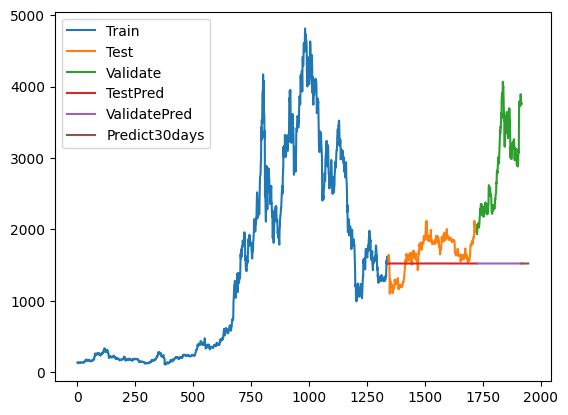

In [20]:
plt.plot(train_data.index, train_data['Close'])
plt.plot(test_data.index, test_data['Close'])
plt.plot(val_data.index, val_data['Close'])
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, y_pred_val)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train','Test','Validate','TestPred','ValidatePred','Predict30days'])
plt.show()